# Recommender System using MovieLens Dataset

importing all required libraries

In [1]:
import re
import ast
import time
import heapq
import decimal
import operator
import subprocess
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import networkx as nx
import rpy2.robjects as ro
from itertools import islice
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter
from operator import itemgetter
from collections import OrderedDict
from networkx.algorithms import community
from rpy2.robjects.packages import importr
from sklearn.datasets import make_regression
from sklearn import datasets, linear_model,tree
from surprise.model_selection import cross_validate, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import Reader, Dataset, SVD, evaluate, accuracy
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.metrics import r2_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
%matplotlib inline

loading user profile from u.user to user_info dataframe

In [2]:
userCols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users_info = pd.read_csv('ml-100k/u.user', sep='|', names=userCols)
users_info.head(5)

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


loading movie profile from u.item to movie_info dataframe

In [3]:
with open('./ml-100k/u.item') as content:
    mCols = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'imdb_url']
    genres = ['unknown', 'action', 'adventure', 'animation', 'children', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 
          'film-noir',  'horror', 'musical', 'mystery', 'romance', 'sci-fi', 'thriller', 'war', 'western']
    mColsG = mCols + genres
    movies_info = pd.DataFrame(columns=mColsG)
    i = 0
    for x in content:
        x = x.split("|")
        x[-1] = x[-1][:-1]
        if x[1][-1] == ' ':
            x[1] = x[1][:-1]
        movies_info.loc[i] = [word if word!='' else "empty" for word in x]
        i = i + 1
movies_info['movie_id'] = movies_info['movie_id'].astype('int64')
movies_info[genres] = movies_info[genres].astype('int64')
movies_info.head(5)

,movie_id,movie_title,release_date,video_release_date,imdb_url,unknown,action,adventure,animation,children,...,fantasy,film-noir,horror,musical,mystery,romance,sci-fi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,empty,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,empty,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,empty,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,empty,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,empty,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


remove video_release_date since column values are empty

In [4]:
if 'video_release_date' in movies_info.columns:
    movies_info = movies_info.drop('video_release_date', axis=1)

creating movie profile with '|' separated genres

In [5]:
movies_genres = movies_info.copy()
named = []
for i in range(0,len(movies_genres)):
    genre = ""
    for column in movies_genres.columns[5:]: 
        if (movies_genres.iloc[i][column] == 1):
            genre = genre + column + '|'
    genre = genre[:-1]
    named.append(genre)
movies_genres['genre_names'] = named
movies_genres['genre_names'] = movies_genres['genre_names'].astype('str')
movies_genres = movies_genres.drop(movies_genres.columns[list(range(4,23))], axis=1) 
movies_genres.head(5)

,movie_id,movie_title,release_date,imdb_url,genre_names
0,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,animation|children|comedy
1,2,GoldenEye (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,action|adventure|thriller
2,3,Four Rooms (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,thriller
3,4,Get Shorty (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...,action|comedy|drama
4,5,Copycat (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),crime|drama|thriller


loading user-movie profile from u.data to user_movie_info dataframe

In [6]:
umCols = ['user_id', 'movie_id', 'rating', 'timestamp']
user_movie_info = pd.read_csv('ml-100k/u.data', sep='\t', names=umCols)
user_movie_info.head(5)

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


creating a new multi_movie dataframe by splitting multi-genre movies into multiple 'same' movies with single genre

In [7]:
new = ([(row['movie_id'], row['movie_title'], row['genre_names'].split('|'))              
                    for _, row in movies_genres.iterrows()])
movCol = ['movie_id', 'movie_title', 'genre']
multi_movie = pd.DataFrame(columns=movCol)
i = 0
for num1 in range(0,len(new)-1):
    for num2 in range(0,len(new[num1][2])):
        multi_movie.loc[i, 'movie_id'] = new[num1][0]
        multi_movie.loc[i, 'movie_title'] = new[num1][1]
        multi_movie.loc[i, 'genre'] = new[num1][2][num2]
        i = i + 1
multi_movie.to_csv('./FINAL/data/movie_genre.txt', columns= ['movie_title', 'genre'] ,sep='\t',index=False,header=False,float_format='%.0f')
multi_movie.head(5)

,movie_id,movie_title,genre
0,1,Toy Story (1995),animation
1,1,Toy Story (1995),children
2,1,Toy Story (1995),comedy
3,2,GoldenEye (1995),action
4,2,GoldenEye (1995),adventure


forming multi_user_movie dataframe after splitting multi-genre movies into multiple 'same' movies with single genre

In [8]:
multi_user_movie = user_movie_info.merge(movies_genres, left_on='movie_id', right_on='movie_id', how='inner')
multi_user_movie.head(5)

,user_id,movie_id,rating,timestamp,movie_title,release_date,imdb_url,genre_names
0,196,242,3,881250949,Kolya (1996),24-Jan-1997,http://us.imdb.com/M/title-exact?Kolya%20(1996),comedy
1,63,242,3,875747190,Kolya (1996),24-Jan-1997,http://us.imdb.com/M/title-exact?Kolya%20(1996),comedy
2,226,242,5,883888671,Kolya (1996),24-Jan-1997,http://us.imdb.com/M/title-exact?Kolya%20(1996),comedy
3,154,242,3,879138235,Kolya (1996),24-Jan-1997,http://us.imdb.com/M/title-exact?Kolya%20(1996),comedy
4,306,242,5,876503793,Kolya (1996),24-Jan-1997,http://us.imdb.com/M/title-exact?Kolya%20(1996),comedy


creating movie_title - rating dataframe

In [9]:
movie_rating = multi_user_movie.copy()
movie_rating = movie_rating.drop(movie_rating.columns[0:2], axis=1)
movie_rating = movie_rating.drop(movie_rating.columns[1:2], axis=1)
movie_rating = movie_rating.drop(movie_rating.columns[2:], axis=1)
movie_rating.head(5)

,rating,movie_title
0,3,Kolya (1996)
1,3,Kolya (1996)
2,5,Kolya (1996)
3,3,Kolya (1996)
4,5,Kolya (1996)


creating movie: [all the ratings of that movie] dictionary

In [10]:
movie_rating_map = {}
#iterate over all movies
for keyval in movie_rating['movie_title']:
    rat = []
    #iterate over all movies rated by a user
    if keyval in movie_rating_map.keys():
        movie_rating_map[keyval].append(movie_rating.loc[movie_rating['movie_title'] == keyval, 'rating'].iloc[len(movie_rating_map[keyval])])
    else:
        rat.append(movie_rating.loc[movie_rating['movie_title'] == keyval, 'rating'].iloc[0])
        movie_rating_map[keyval] = rat
#movie_rating_map

creating movie: average rating dictionary

In [11]:
avg_rating_map = {}
for k,v in movie_rating_map.items():
    avg_rating_map[k] = sum(v)/ float(len(v))
#avg_rating_map

converting the above dictionary to dataframe

In [12]:
avg_rating = pd.DataFrame(columns=['movie_title', 'rating'])
index = 0
for k,v in avg_rating_map.items():
    index = index + 1
    avg_rating.loc[index, 'movie_title'] = k
    avg_rating.loc[index, 'rating'] = v
#avg_rating_map

saving the above dataframe to file

In [13]:
avg_rating.to_csv('./FINAL/data/movie_avg_rating.txt', columns= ['movie_title', 'rating'] ,sep='\t',index=False,header=False,float_format='%.0f',encoding='latin-1')

removing columns with unknown values

In [14]:
multi_user_movie = multi_user_movie[multi_user_movie['movie_title'] != 'unknown']
multi_user_movie = multi_user_movie[multi_user_movie['release_date'] != 'empty']
multi_user_movie.to_csv('./FINAL/data/jlt/multi_user_movie_full.txt', sep='\t',index=False,header=False,float_format='%.0f')
multi_user_movie.to_csv('./FINAL/data/jlt/multi_user_movie.txt', columns= ['user_id', 'movie_title'] ,sep='\t',index=False,header=False,float_format='%.0f')
ncols = ['user_id', 'movie_id', 'rating', 'timestamp', 'movie_title','release_date', 'imdb_url', 'genre_names']
multi_user_movie = pd.read_csv('./FINAL/data/jlt/multi_user_movie_full.txt', sep='\t', names=ncols, encoding='latin-1')

#### Content Based Recommendation (CBR)

Since we want to build personalised recommendation, we compute similarity between movies based on certain metrics. Then, we can safely deduce/predict the movies that the user will like based on movie previously liked by the user. This is done using the similarity metric which is based on the attributes/content of the movies. Hence, it's called Content Based Recommendation (CBR). We can build the CBR model based on either all or a subset of a movie's attributes.

Suppose, we build a CBR model with the movie name as one such attribute. For example, a movie 'Love Actually' and 'Love Story' would both fall into 'Romance' genre. Hence, based on the movie name, we can cluster similar named movies. However, this is NOT the best approach since it might also be misleading. For example, a movie 'Gone With The Wind' (Romance) might have nothing to do with 'Wind Chill' (Horror). We see this below.

removing movie year from the movie name

In [15]:
movie_without_year = movies_genres.copy()
movie_without_year['movie_title'] = movie_without_year['movie_title'].map(lambda x: str(x)[:-7])
movie_without_year.head(5)

,movie_id,movie_title,release_date,imdb_url,genre_names
0,1,Toy Story,01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,animation|children|comedy
1,2,GoldenEye,01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,action|adventure|thriller
2,3,Four Rooms,01-Jan-1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,thriller
3,4,Get Shorty,01-Jan-1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...,action|comedy|drama
4,5,Copycat,01-Jan-1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),crime|drama|thriller


using tf–idf (term frequency–inverse document frequency) to identify repetition of words in the movie names to recommend other movies having similar names

In [16]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
#returns T x D i.e. term document matrix
tfidf_matrix = tf.fit_transform(movies_info['movie_title'])

Using cosine similarity: to compute similarity between two movies: cosine(x,y)= x.(y⊺) / (||x||.||y||) 

In [17]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

getting a DF of indices of each movie with movie name as index

In [18]:
indices = pd.Series(movie_without_year.index, index=movie_without_year['movie_title'])

using this pairwise cosine similarity matrix for all the movies, we define a function that returns the topmost similar movies based on the cosine similarity score

In [19]:
def get_similar(title):
    print("The genre of the given movie is:", movie_without_year.loc[movie_without_year['movie_title']==title,'genre_names'].iloc[0])
    idx = indices[title]
    sim_score = list(enumerate(cosine_sim[idx]))
    sim_score = sorted(sim_score, key=lambda x: x[1], reverse=True)
    sim_score = sim_score[1:11]#top10
    movie_indices = [i[0] for i in sim_score]
    for num in movie_indices:
        print(movie_without_year['movie_title'].iloc[num],": ",movie_without_year['genre_names'].iloc[num])

checking the effectiveness of our approach by getting movie recommendations using CBR

In [20]:
get_similar('Toy Story')

The genre of the given movie is: animation|children|comedy
Pyromaniac's Love Story, A :  comedy|romance
Now and Then :  drama
Show, The :  documentary
To Have, or Not :  drama
Story of Xinghua, The :  drama
Philadelphia Story, The :  comedy|romance
NeverEnding Story III, The :  children|fantasy
FairyTale: A True Story :  children|drama|fantasy
Entertaining Angels: The Dorothy Day Story :  drama
Police Story 4: Project S (Chao ji ji hua) :  action


In [21]:
get_similar('Love Serenade')

The genre of the given movie is: comedy
Love Is All There Is :  comedy|drama
Penny Serenade :  drama|romance
She's the One :  comedy|romance
Two Much :  comedy|romance
Before and After :  drama|mystery
A Chef in Love :  comedy
Pompatus of Love, The :  comedy|drama
Hotel de Love :  comedy|romance
Everyone Says I Love You :  comedy|musical|romance
In Love and War :  romance|war


#### Collaborative Filtering (CF)

We see that the predictions are not so accurate since some genres differ by a lot. Hence, such a text mining approach would have been more useful, if we were given more details about the movies such as movie synopsis, cast, crew etc. This model doesn't give user-specific recommendations. Hence, to overcome this limitation arising due to limited descriptive data available in the MovieLens dataset, we compute user1's preference based on another similar user2's preference on the movies that the latter has reviewed but the former hasn't. This approach is called Collaborative Filtering (CF). We use Surprise library to implement CF.

splitting data into 10-folds and performing SVD

In [22]:
reader = Reader()
data = Dataset.load_from_df(user_movie_info[['user_id', 'movie_id', 'rating']], reader)
#dividing the data into k-folds, here k=10
kf = KFold(n_splits=10)
#using SVD
algo = SVD()

performing training, testing and calculating RMSE

In [23]:
for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.9337
RMSE: 0.9366
RMSE: 0.9233
RMSE: 0.9362
RMSE: 0.9310
RMSE: 0.9295
RMSE: 0.9294
RMSE: 0.9287
RMSE: 0.9251
RMSE: 0.9231


checking the effectiveness of our approach by getting movie recommendations using CF - predicting the rating for user_id = 10 and movie_id = 336

In [24]:
trainset = data.build_full_trainset()
algo.fit(trainset)
algo.predict(10, 336, 3)

Prediction(uid=10, iid=336, r_ui=3, est=3.018871413532989, details={'was_impossible': False})

Here, we get a predicted rating of 3.10 for user_id = 10 and movie_id = 336. This CF approach of movie recommendation is independent of the content of the movie (like genres etc.) since the basis of its prediction is solely on how other similar users have rated the movie. However, this is also not the best way to approach the problem. So, we move on to actually making use of the attributes of each review for a movie by a user by performing feature engineering.

#### Feature Engineering

Here, we add a new feature: timeSinceRelease = timestamp - release_date. Other features like day of the week, month of the year can also be added.

converting time columns into datetime format

In [25]:
multi_user_movie['release_date'] = pd.to_datetime(multi_user_movie['release_date'], format='%d-%b-%Y')
for i in range(0,len(multi_user_movie)):
    multi_user_movie.loc[i,'timestamp'] = datetime.fromtimestamp(multi_user_movie.loc[i,'timestamp'])
multi_user_movie['timestamp'] = pd.to_datetime(multi_user_movie['timestamp'], format='%d-%b-%Y')

creating a function to get the timespan between two datetime objects

In [26]:
def days_between(d1, d2):
    return abs((d1 - d2).days)

creating timeSinceRelease column

In [27]:
ctr = 0
for i in multi_user_movie['movie_title']:
    multi_user_movie.loc[ctr,'timeSinceRelease'] = days_between(multi_user_movie.loc[ctr,'timestamp'],multi_user_movie.loc[ctr,'release_date'])
    ctr = ctr + 1

creating dict out of this dataframe for all, min and max review release span of a movie 

In [28]:
all_timespan = {}
cnt = 0
for mov in multi_user_movie['movie_title']:
    nummin = 0
    nummax = 0
    m = []
    if mov in all_timespan.keys():
        all_timespan[mov].append(multi_user_movie.loc[multi_user_movie['movie_title'] == mov, 'timeSinceRelease'].iloc[len(all_timespan[mov])])
    else:
        cnt = cnt + 1
        m.append(multi_user_movie.loc[multi_user_movie['movie_title'] == mov, 'timeSinceRelease'].iloc[0])
        all_timespan[mov] = m

creating dictionary for timespan for each review of a movie

In [29]:
min_timespan_dict = {}
max_timespan_dict = {}
timespan_dict = {}

for ur in all_timespan.keys():
    if ur in min_timespan_dict.keys():
        continue
    #using min-heap and max-heap
    else:
        if all_timespan[ur] != []:
            min_timespans = all_timespan[ur]
            heapq.heapify(min_timespans)
            min_timespan_dict[ur] = heapq.heappop(min_timespans)
    if ur in max_timespan_dict.keys():
        continue
    else:
        if all_timespan[ur] != []:
            max_timespans = all_timespan[ur]
            heapq._heapify_max(max_timespans)
            max_timespan_dict[ur] = heapq._heappop_max(max_timespans)
    if ur in timespan_dict.keys():
        continue
    else:
        if all_timespan[ur] != []:
            timespan_dict[ur] = [max_timespan_dict[ur] - min_timespan_dict[ur]]

converting the above dictionary to a dataframe

In [30]:
timespan = pd.DataFrame.from_dict(timespan_dict)
timespan = timespan.T
timespan.reset_index(level=0, inplace=True)
timespan.columns = ['movie_title', 'timespan']
timespan.head(5)

,movie_title,timespan
0,'Til There Was You (1997),188.0
1,1-900 (1994),122.0
2,101 Dalmatians (1996),214.0
3,12 Angry Men (1957),213.0
4,187 (1997),207.0


saving the dataframe to file

In [31]:
timespan.to_csv('./FINAL/data/features/movie_timespan.txt',sep='\t',index=False,header=False,float_format='%.0f')

creating users: [all the movies the user has rated] dictionary

In [32]:
user_movie_map = {}
cnt = 0
for user in multi_user_movie['user_id']:
    mov=[]
    if user in user_movie_map.keys():
        user_movie_map[user].append(multi_user_movie.loc[multi_user_movie['user_id'] == user, 'movie_title'].iloc[len(user_movie_map[user])])
    else:
        cnt = cnt + 1
        mov.append(multi_user_movie.loc[multi_user_movie['user_id'] == user, 'movie_title'].iloc[0])
        user_movie_map[user] = mov
#user_movie_map

converting the above dictionary to dataframe

In [33]:
user_movie = pd.DataFrame(columns=['user_id', 'movie_title'])
index = 0
for k,v in user_movie_map.items():
    index = index + 1
    user_movie.loc[index, 'user_id'] = k
    user_movie.loc[index, 'movie_title'] = v
user_movie.head(5)

,user_id,movie_title
1,196,"[Kolya (1996), Men in Black (1997), Truth Abou..."
2,63,"[Kolya (1996), L.A. Confidential (1997), Men i..."
3,226,"[Kolya (1996), Dr. Strangelove or: How I Learn..."
4,154,"[Kolya (1996), L.A. Confidential (1997), Dr. S..."
5,306,"[Kolya (1996), Men in Black (1997), Fargo (199..."


saving the above dataframe to file

In [34]:
user_movie.to_csv('./FINAL/data/user_movies.txt', columns= ['user_id', 'movie_title'] ,sep='\t',index=False,header=False,float_format='%.0f')

creating list of all users

In [35]:
um1 = []
um1 = list(user_movie_map.keys())
um2 = []
um2 = list(user_movie_map.keys())

performing graph computations - calculating edge weights for weighted directed user movie graph

In [36]:
weighted_directed_user_movie_graph = open("./FINAL/data/wd_um_graph.txt", 'w')
p = 0
counter = 0
print("The total number of nodes in the graph: ",len(user_movie_map))
while p < len(um1):
    u1 = um1[p]
    u1m = user_movie_map[u1]
    #cos we don't to check for the same user with him/herself!
    q = p + 1 
    while q < len(um2):
        u2 = um2[q]
        u2m = user_movie_map[u2]
        overlap_movies = set(u1m) & set(u2m)
        #edge weight tells us what proportion of movies do two users have rated in common
        if len(overlap_movies) > 0:
            u1Ratio = decimal.Decimal(len(overlap_movies)) \
                / decimal.Decimal(len(u1m))
            u1Ratio = format(u1Ratio, '.3f')
            u2Ratio = decimal.Decimal(len(overlap_movies)) \
                / decimal.Decimal(len(u2m))
            u2Ratio = format(u2Ratio, '.3f')
            weighted_directed_user_movie_graph.write(u1.astype(str) + '\t' + u2.astype(str) + '\t' + str(u1Ratio) + '\n')
            weighted_directed_user_movie_graph.write(u2.astype(str) + '\t' + u1.astype(str) + '\t' + str(u2Ratio) + '\n')
            counter = counter + 1
        q = q + 1
    p = p + 1

The total number of nodes in the graph:  943


#### Call R script for weighted directed user network: WD_user

creating movie: [all the users that rated this movie] dictionary

In [37]:
#iterate over all users
movie_user_map = {}
for keyval in user_movie_map.keys():
    #iterate over all movies rated by a user
    for movie in user_movie_map[keyval]:
        if (movie in movie_user_map):
            user_list = movie_user_map[movie]
            if keyval not in user_list:
                user_list.append(keyval)         
                movie_user_map[movie] = user_list
        else:
            movie_user_map[movie] = [keyval]

creating list of all movies

In [38]:
mov1 = []
mov1 = list(movie_user_map.keys())
mov2 = []
mov2 = list(movie_user_map.keys())

performing graph computations - calculating edge weights for weighted undirected movie user graph

In [39]:
weighted_undirected_movie_graph = open("./FINAL/data/wu_movie_graph.txt", 'w')
p = 0
counter = 0
print("The total number of nodes in the graph:",len(mov1))
while p < len(mov1):
    mov1_id = mov1[p]
    mov1_users = movie_user_map[mov1_id]
    q = p + 1
    while q < len(mov2):
        mov2_id = mov2[q]
        mov2_users = movie_user_map[mov2_id]
        overlap_actors = set(mov1_users) & set(mov2_users)
        if(len(overlap_actors) > 0):
            #calculating jaccard index as edge weight
            jaccard_index = decimal.Decimal(len(overlap_actors) * 100)/(decimal.Decimal(len(mov1_users) + len(mov2_users) - len(overlap_actors)))
            weighted_undirected_movie_graph.write(str(mov1_id) + "\t" + str(mov2_id) + "\t" + str(jaccard_index) + "\n")
            counter = counter + 1
        q = q + 1
    p = p + 1

The total number of nodes in the graph: 1663


#### Call R script for weighted undirected movie network: WU_movie

creating user_id: pagerank dictionary

In [40]:
pg_reader = open("./FINAL/data/top943userpg.txt", "r")
page_rank = {}
for row in pg_reader.readlines():
    content = row.strip().split('\t')
    content[0] = content[0].strip('""')
    page_rank[content[0]] = float(ast.literal_eval(content[1]))

building unordered set with unique user_id

In [41]:
page_rank = {int(k):float(v) for k, v in page_rank.items()}

building movie - pageranks of users that rated that movie dictionary

In [42]:
movie_pagerank = {}
for key in user_movie_map.keys():
    usr = key
    mvs = user_movie_map[usr]
    pgval = page_rank[usr]
    for value in mvs:
        if value not in movie_pagerank:
            movie_pagerank[value] = []
        movie_pagerank[value].append(pgval)
#movie_pagerank

checking number of pagerank values in movie - pageranks of users dictionary

In [43]:
nu = 0
for i in movie_pagerank.keys():
    nu = nu + len(movie_pagerank[i])
print("The total number of pg values are:", nu)
nuumin = 583
nuumax = 0
#length of pg values for each user- find max
for i in movie_pagerank.keys():
    if len(movie_pagerank[i]) < nuumin:
        nuumin = len(movie_pagerank[i])
    if len(movie_pagerank[i]) > nuumax:
        nuumax = len(movie_pagerank[i])
#might not be equal to number of users since one user could have rated more than one movie
print("The min number of pg values are:", nuumin)
print("The max number of pg values are:", nuumax)

The total number of pg values are: 99991
The min number of pg values are: 1
The max number of pg values are: 583


creating output file with top 5 pageranks of each movie

In [44]:
output_file = open('./FINAL/data/features/movie_pageranks_top5.txt',"w")
for movie in movie_pagerank.keys():
    pagerank_val = movie_pagerank[movie]
    pagerank_val.sort(reverse=True)
    str_pagerank =""
    for val in range(0,5):#specifies number of (top) pagerank values to be taken (since sorted in decreasing order)
        if(val< len(pagerank_val)):
            y = pagerank_val[val]
            str_pagerank = str_pagerank+str(y)+"\t"
        else:
            str_pagerank = str_pagerank+"0"+"\t"
    final = movie+"\t"+str_pagerank+"\n"
    output_file.write(final)

reading the avg. ratings of movies from file to ratings dataframe

In [45]:
ratings = pd.read_csv('./FINAL/data/movie_avg_rating_processed.txt', sep='\t', names=['movie_title','rating'],encoding='latin-1')
ratings = ratings.drop(ratings.index[0])
ratings.head(5)

,movie_title,rating
1,Kolya (1996),3.99145299145
2,L.A. Confidential (1997),4.16161616162
3,Heavyweights (1994),2.15384615385
4,Legends of the Fall (1994),3.45679012346
5,Jackie Brown (1997),3.64285714286


creating movie - avg. rating dictionary

In [46]:
movie_avg_rating_dict = {}
for val in range(1,len(ratings)):
    movie_avg_rating_dict[ratings.loc[val,'movie_title']] = ratings.loc[val,'rating']
#movie_avg_rating_dict

removing unknown movie names

In [48]:
for keyval,_ in movie_avg_rating_dict.items():#mrate.keys():
    if keyval == 'unknown':
        del movie_avg_rating_dict[keyval]

converting the above dictionary to dataframe

In [49]:
movie_avg_rating = pd.DataFrame(list(movie_avg_rating_dict.items()), columns=['movie_title', 'rating'])
movie_avg_rating.head(5)

,movie_title,rating
0,Kolya (1996),3.99145299145
1,L.A. Confidential (1997),4.16161616162
2,Heavyweights (1994),2.15384615385
3,Legends of the Fall (1994),3.45679012346
4,Jackie Brown (1997),3.64285714286


creating a movie - timespan dictionary

In [50]:
md_reader = open('./FINAL/data/features/movie_timespan.txt', 'r')
movies = []
tsp = []
i = 1
for md in md_reader:
    content = md.strip().split("\t")
    for x in content:
        movies.append(content[0])
        tsp.append(content[1])
    i += 1
movies_timespan_dict = dict(zip(movies, tsp))
#movies_timespan_dict

converting the above dictionary to dataframe

In [51]:
movies_timespan = pd.DataFrame(list(movies_timespan_dict.items()), columns=['movie_title', 'timespan'])
movies_timespan.head(5)

,movie_title,timespan
0,'Til There Was You (1997),188
1,1-900 (1994),122
2,101 Dalmatians (1996),214
3,12 Angry Men (1957),213
4,187 (1997),207


creating DF with top 5 pageranks for users that rated that movie

In [52]:
movies_pageranks_top_5 = pd.read_csv('./FINAL/data/movie_pageranks.txt', sep="\t", encoding='latin-1',header = None, names = ['movie_title','pg1','pg2','pg3','pg4','pg5','rating'])#,'Timespan'])
movies_pageranks_top_5['rating'] = 0
movies_timespan_pagerank = movies_timespan.merge(movies_pageranks_top_5, left_on='movie_title', right_on='movie_title', how='inner')
movies_pageranks_top_5.head(5)

,movie_title,pg1,pg2,pg3,pg4,pg5,rating
0,Kolya (1996),0.003701,0.003484,0.003370,0.003293,0.003049,0
1,Men in Black (1997),0.003484,0.003370,0.003343,0.003241,0.003012,0
2,"Truth About Cats & Dogs, The (1996)",0.003701,0.003484,0.003406,0.003370,0.003293,0
3,"Birdcage, The (1996)",0.003701,0.003484,0.003406,0.003370,0.003343,0
4,"Adventures of Priscilla, Queen of the Desert, ...",0.003701,0.003484,0.003406,0.003343,0.003293,0


converting timespan to integer type

In [53]:
movies_timespan_pagerank['timespan'] = movies_timespan_pagerank['timespan'].astype('int64')
movies_timespan_pagerank.head(5)

,movie_title,timespan,pg1,pg2,pg3,pg4,pg5,rating
0,'Til There Was You (1997),188,0.003370,0.002592,0.002173,0.001925,0.001600,0
1,1-900 (1994),122,0.002679,0.001992,0.001892,0.001875,0.000441,0
2,101 Dalmatians (1996),214,0.003701,0.003406,0.003370,0.003343,0.003012,0
3,12 Angry Men (1957),213,0.003701,0.003484,0.003406,0.003370,0.003293,0
4,187 (1997),207,0.003484,0.003370,0.003293,0.003241,0.002805,0


filling up rating column of fdf

In [54]:
tsps = []
movies = []
nrows = movies_timespan_pagerank.shape[0]
for i in range(0,nrows):
    movie = movies_pageranks_top_5.iloc[i,0]
    if movie in movie_avg_rating_dict:
        movies_timespan_pagerank.iloc[i,7] = movie_avg_rating_dict[movie]

drop columns without values

In [55]:
movies_timespan_pagerank = movies_timespan_pagerank.dropna() 

preparing baseline feature dataframe - baseline model is trained on: age, gender, occupation, genres

In [56]:
merged1 = user_movie_info.merge(movies_info, left_on='movie_id', right_on='movie_id', how='inner')
merged2 = merged1.merge(users_info, left_on='user_id', right_on='user_id', how='inner')
rqdCols = ['user_id','movie_title','age','occupation','gender']+genres#+['rating']
baseline = merged2[rqdCols]
#keeping non-empty values
baseline = baseline[baseline['gender'] != 'empty']
baseline = baseline[baseline['occupation'] != 'empty']

since gender and occupation are categorical features, they are one-hot encoded below

In [57]:
baseline['occupation'] = baseline['occupation'].astype('category')
baseline['gender'] = baseline['gender'].astype('category')
one_hot_occ = baseline.occupation.str.get_dummies()
baseline = baseline.drop('occupation',axis=1)
baseline = baseline.join(one_hot_occ,how='inner')
one_hot_g = baseline.gender.str.get_dummies()
baseline = baseline.drop('gender',axis=1)
baseline = baseline.join(one_hot_g,how='inner')
baseline = baseline.merge(avg_rating, left_on='movie_title', right_on='movie_title', how='inner')
baseline = baseline.drop('user_id',axis=1)
baseline.head(5)

,movie_title,age,unknown,action,adventure,animation,children,comedy,crime,documentary,...,programmer,retired,salesman,scientist,student,technician,writer,F,M,rating
0,Kolya (1996),49,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,3.99145
1,Kolya (1996),31,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,3.99145
2,Kolya (1996),28,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,3.99145
3,Kolya (1996),25,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,3.99145
4,Kolya (1996),45,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,3.99145


The new features that are added are: 
1. timespan between movie release and review date
2. pageranks of the top 5 users that have rated that movie

preparing feature dataframe including engineered features

In [58]:
movies_timespan_pagerank = movies_timespan_pagerank.drop('rating',axis=1)
final = movies_timespan_pagerank.merge(baseline, left_on='movie_title', right_on='movie_title', how='inner') 

splitting dataframe including engineered features into test and train data

In [59]:
X = final.iloc[:,1:50]
y = final.iloc[:,50:]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
test_size=0.20, random_state=0)

##### Baseline Modelling (without engineered features)

splitting baseline dataframe into test and train data

In [60]:
X_base = baseline.iloc[:,1:44]
y_base = baseline.iloc[:,44:]
X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(X_base, y_base, 
test_size=0.20, random_state=0)

training the model

In [61]:
baseline_method = tree.DecisionTreeRegressor()
model_baseline = baseline_method.fit(X_base_train, y_base_train)

getting the ratings for some example movies

In [62]:
for i in range(1, len(baseline)):
    movie = baseline.iloc[i, 0]
    if(movie == 'Little Buddha (1993)'):
        mov1_feature = baseline.iloc[i,1:44]
    if(movie == 'Little Big League (1994)'):
        mov2_feature = baseline.iloc[i,1:44]
    if (movie == 'Metro (1997)'):
        mov3_feature = baseline.iloc[i, 1:44]
print("prediction for Little Buddha (1993)")
print(model_baseline.predict([mov1_feature]))
print("prediction for Little Big League (1994)")
print(model_baseline.predict([mov2_feature]))
print("prediction for Metro (1997)")
print(model_baseline.predict([mov3_feature]))

prediction for Little Buddha (1993)
[ 3.71158207]
prediction for Little Big League (1994)
[ 2.82887762]
prediction for Metro (1997)
[ 2.95523888]


checking the effectiveness of the model on test data

In [63]:
print("testing score: ",(model_baseline.score(X_base_test, y_base_test)))
print("\n")

testing score:  0.233581015156




since the baseline model is giving a score of 0.23 it doesn't seem to be performing well, we try linear regression

performing correlation analysis between features before performing multiple regression, begin by finding correlation matrix

In [64]:
correlation_matrix = final.corr()
correlation_matrix.head(5)

,timespan,pg1,pg2,pg3,pg4,pg5,age,unknown,action,adventure,...,other,programmer,retired,salesman,scientist,student,technician,writer,F,M
timespan,1.000000,0.233473,0.385734,0.470963,0.489895,0.503406,-0.024938,NaN,0.066371,0.095154,...,0.003343,0.019920,-0.013621,-0.003093,0.009214,0.006403,0.018963,-0.008016,-0.020024,0.020024
pg1,0.233473,1.000000,0.744092,0.677540,0.647486,0.635046,0.038706,NaN,0.149296,0.049071,...,-0.004244,0.003011,-0.002318,0.004339,0.019094,-0.008378,0.005769,-0.004127,-0.024366,0.024366
pg2,0.385734,0.744092,1.000000,0.892831,0.843782,0.814290,0.024033,NaN,0.107433,0.041279,...,-0.004589,0.009274,-0.005042,0.004801,0.022616,-0.001000,0.010226,-0.012405,-0.020985,0.020985
pg3,0.470963,0.677540,0.892831,1.000000,0.943896,0.904711,0.009415,NaN,0.132035,0.057067,...,-0.003692,0.014827,-0.007164,0.006075,0.022622,0.005167,0.017110,-0.014307,-0.029421,0.029421
pg4,0.489895,0.647486,0.843782,0.943896,1.000000,0.956869,0.001800,NaN,0.144187,0.062767,...,-0.000493,0.016289,-0.007578,0.007408,0.023063,0.008216,0.017728,-0.015979,-0.031369,0.031369


function for finding most correlated features

In [65]:
def mostcorrelated(mydf, n):
    cormatrix = mydf.corr()
    #set the correlations on diagnol or lower triangle to zero
    #don't want duplicacy of correlations when ranking them
    cormatrix *= np.tri(*cormatrix.values.shape, k=-1).T
    cormatrix = cormatrix.stack() #gives top n correlation values
    cormatrix = cormatrix.reindex(cormatrix.abs().sort_values(ascending=False).index).reset_index()
    cormatrix.columns = ["Variable 1", "Variable 2", "Correlation"]
    return cormatrix.head(n)

checking most correlated features

In [66]:
mostcorrelated(final, 26)

,Variable 1,Variable 2,Correlation
0,F,M,-1.000000
1,pg4,pg5,0.956869
2,pg3,pg4,0.943896
3,pg3,pg5,0.904711
4,pg2,pg3,0.892831
5,pg2,pg4,0.843782
6,pg2,pg5,0.814290
7,pg1,pg2,0.744092
8,pg1,pg3,0.677540
9,pg1,pg4,0.647486


finding correlation between genres

In [67]:
correlation_genres = final.iloc[:,9:27].corr()
correlation_genres.head(5)

,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film-noir,horror,musical,mystery,romance,sci-fi,thriller,war,western
action,1.000000,0.451618,-0.099302,-0.145225,-0.223550,0.007265,-0.050102,-0.270195,-0.013962,-0.078007,-0.007772,-0.091503,-0.033072,-0.018905,0.323816,0.249325,0.166623,0.063578
adventure,0.451618,1.000000,-0.024931,0.100400,-0.113261,-0.030133,-0.034127,-0.223751,0.087755,-0.053135,-0.058823,-0.025014,-0.043869,-0.018998,0.294575,-0.049807,0.086913,0.010522
animation,-0.099302,-0.024931,1.000000,0.555408,0.029559,-0.057346,-0.016529,-0.157695,0.026095,-0.025736,-0.028468,0.417622,-0.045619,-0.085678,-0.044934,-0.077404,-0.056582,-0.026637
children,-0.145225,0.100400,0.555408,1.000000,0.082959,-0.082480,-0.023774,-0.129979,0.238169,-0.037015,-0.066067,0.381296,-0.055181,-0.119645,-0.042476,-0.144566,-0.085594,-0.031125
comedy,-0.223550,-0.113261,0.029559,0.082959,1.000000,-0.090999,-0.055676,-0.347605,0.017190,-0.086686,-0.074298,0.034936,-0.111626,0.095764,-0.146069,-0.291075,-0.120086,0.002502


generating heatmap to visualise the correlation among genres

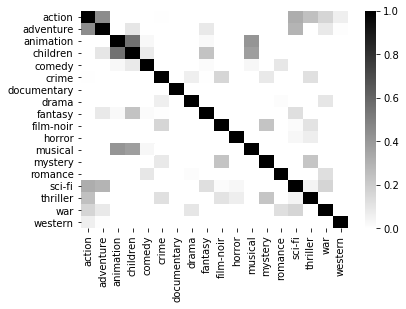

In [68]:
sns.heatmap(correlation_genres, vmin=0, vmax=1., square=False, cmap="gray_r")

finding correlation between occupations

In [69]:
correlation_occupation = final.iloc[:,28:48].corr()
correlation_occupation.head(5)

,artist,doctor,educator,engineer,entertainment,executive,healthcare,homemaker,lawyer,librarian,marketing,none,other,programmer,retired,salesman,scientist,student,technician,writer
artist,1.000000,-0.011301,-0.049528,-0.045787,-0.022439,-0.028656,-0.025699,-0.008406,-0.017917,-0.036195,-0.021632,-0.014629,-0.052959,-0.044605,-0.019562,-0.014264,-0.022230,-0.081387,-0.029236,-0.037133
doctor,-0.011301,1.000000,-0.023821,-0.022022,-0.010792,-0.013782,-0.012360,-0.004043,-0.008617,-0.017408,-0.010404,-0.007036,-0.025471,-0.021453,-0.009409,-0.006860,-0.010692,-0.039144,-0.014061,-0.017859
educator,-0.049528,-0.023821,1.000000,-0.096517,-0.047301,-0.060405,-0.054172,-0.017721,-0.037769,-0.076298,-0.045599,-0.030837,-0.111636,-0.094024,-0.041237,-0.030068,-0.046861,-0.171561,-0.061629,-0.078274
engineer,-0.045787,-0.022022,-0.096517,1.000000,-0.043728,-0.055842,-0.050080,-0.016382,-0.034916,-0.070534,-0.042154,-0.028508,-0.103203,-0.086922,-0.038122,-0.027796,-0.043321,-0.158602,-0.056973,-0.072361
entertainment,-0.022439,-0.010792,-0.047301,-0.043728,1.000000,-0.027367,-0.024543,-0.008028,-0.017112,-0.034568,-0.020659,-0.013971,-0.050578,-0.042599,-0.018683,-0.013622,-0.021231,-0.077728,-0.027922,-0.035463


generating heatmap to visualise the correlation among occupation

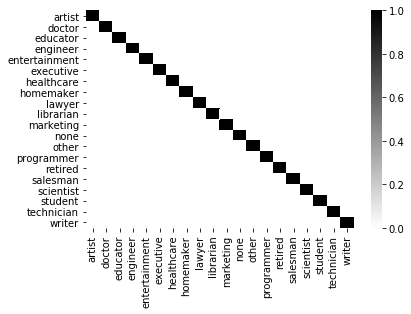

In [70]:
sns.heatmap(correlation_occupation, vmin=0, vmax=1., square=False, cmap="gray_r")

finding correlation between pageranks

In [71]:
correlation_pagerank = final.iloc[:,2:7].corr()
correlation_pagerank.head(5)

,pg1,pg2,pg3,pg4,pg5
pg1,1.000000,0.744092,0.677540,0.647486,0.635046
pg2,0.744092,1.000000,0.892831,0.843782,0.814290
pg3,0.677540,0.892831,1.000000,0.943896,0.904711
pg4,0.647486,0.843782,0.943896,1.000000,0.956869
pg5,0.635046,0.814290,0.904711,0.956869,1.000000


generating heatmap to visualise the correlation among pageranks

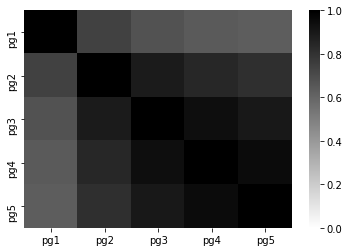

In [72]:
sns.heatmap(correlation_pagerank, vmin=0, vmax=1., square=False, cmap="gray_r")

##### Linear Regression

training the model

In [73]:
regression1 = linear_model.LinearRegression()
model_regression1 = regression1.fit(X_train, y_train)

getting the ratings for some example movies

In [74]:
for i in range(1, len(final)):
    movie = final.iloc[i, 0]
    if(movie == 'Little Buddha (1993)'):
        mov1_feature = final.iloc[i,1:50]
    if(movie == 'Little Big League (1994)'):
        mov2_feature = final.iloc[i,1:50]
    if (movie == 'Metro (1997)'):
        mov3_feature = final.iloc[i, 1:50]
print("prediction for Little Buddha (1993)")
print(regression1.predict([mov1_feature]))
print("prediction for Little Big League (1994)")
print(regression1.predict([mov2_feature]))
print("prediction for Metro (1997)")
print(regression1.predict([mov3_feature]))
print("\n")

prediction for Little Buddha (1993)
[[ 3.43663628]]
prediction for Little Big League (1994)
[[ 2.5772907]]
prediction for Metro (1997)
[[ 3.16664091]]




plotting true values v/s predictions of linear regression (top 100 values)

Text(0.5,1,'Linear Regression Model')

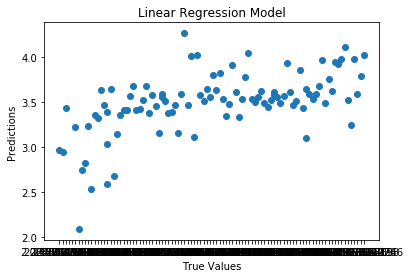

In [75]:
predictions = regression1.predict(X_test)
plt.scatter(y_test[0:100], predictions[0:100])
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Linear Regression Model')

performing 10-fold CV and checking the effectiveness of the model on test data

In [76]:
regression1_scores = cross_val_score(model_regression1, X_train, y_train, cv = 10)
print("cross validation scores: \n",regression1_scores)
print("testing score: {}".format(model_regression1.score(X_test, y_test)))
print("\n")

cross validation scores: 
 [ 0.34028047  0.37086327  0.31849793  0.32726282  0.34128561  0.33365316
  0.36486928  0.34915655  0.3538425   0.35127401]
testing score: 0.34936911490234035




##### Linear Regression - without pageranks

preparing feature dataframe including engineered features without pageranks

In [77]:
final_without_pagerank = final.drop(final.columns[1:7], axis=1)

splitting into test and train data

In [78]:
X_pg = final_without_pagerank.iloc[:,1:44]
y_pg = final_without_pagerank.iloc[:,44:]
X_pg_train, X_pg_test, y_pg_train, y_pg_test = train_test_split(X_pg, y_pg, 
test_size=0.20, random_state=0)

training the model

In [79]:
regression2 = linear_model.LinearRegression()
model_regression2 = regression2.fit(X_pg_train, y_pg_train)

getting the ratings for some example movies

In [80]:
for i in range(1, len(final_without_pagerank)):
    movie = final_without_pagerank.iloc[i, 0]
    if(movie == 'Little Buddha (1993)'):
        mov1_feature = final_without_pagerank.iloc[i,1:44]
    if(movie == 'Little Big League (1994)'):
        mov2_feature = final_without_pagerank.iloc[i,1:44]
    if (movie == 'Metro (1997)'):
        mov3_feature = final_without_pagerank.iloc[i, 1:44]
print("prediction for Little Buddha (1993)")
print(regression2.predict([mov1_feature]))
print("prediction for Little Big League (1994)")
print(regression2.predict([mov2_feature]))
print("prediction for Metro (1997)")
print(regression2.predict([mov3_feature]))
print("\n")

prediction for Little Buddha (1993)
[[ 3.60122681]]
prediction for Little Big League (1994)
[[ 3.03174973]]
prediction for Metro (1997)
[[ 3.44247055]]




performing 10-fold CV and checking the effectiveness of the model on test data

In [81]:
regression2_scores = cross_val_score(model_regression2, X_pg_train, y_pg_train, cv = 10)
print("cross validation scores: \n",regression2_scores)
print("testing score: {}".format(model_regression2.score(X_pg_test, y_pg_test)))
print("\n")

cross validation scores: 
 [ 0.15381911  0.17596597  0.15118868  0.15191291  0.17656254  0.16590944
  0.17546368  0.15832855  0.16362594  0.16190098]
testing score: 0.16523580631806178




##### Linear Regression - without genres

preparing feature dataframe including engineered features without genres

In [82]:
final_without_genre = final.drop(final.columns[8:27], axis=1)

splitting into test and train data

In [83]:
X_genre = final_without_genre.iloc[:,1:31]
y_genre = final_without_genre.iloc[:,31:]
X_genre_train, X_genre_test, y_genre_train, y_genre_test = train_test_split(X_genre, y_genre, 
test_size=0.20, random_state=0)

training the model

In [84]:
regression3 = linear_model.LinearRegression()
model_regression3 = regression3.fit(X_genre_train, y_genre_train)

getting the ratings for some example movies

In [85]:
for i in range(1, len(final_without_genre)):
    movie = final_without_genre.iloc[i, 0]
    if(movie == 'Little Buddha (1993)'):
        mov1_feature = final_without_genre.iloc[i,1:31]
    if(movie == 'Little Big League (1994)'):
        mov2_feature = final_without_genre.iloc[i,1:31]
    if (movie == 'Metro (1997)'):
        mov3_feature = final_without_genre.iloc[i, 1:31]
print("prediction for Little Buddha (1993)")
print(regression3.predict([mov1_feature]))
print("prediction for Little Big League (1994)")
print(regression3.predict([mov2_feature]))
print("prediction for Metro (1997)")
print(regression3.predict([mov3_feature]))
print("\n")

prediction for Little Buddha (1993)
[[ 3.28399508]]
prediction for Little Big League (1994)
[[ 2.93354486]]
prediction for Metro (1997)
[[ 3.33451242]]




performing 10-fold CV and checking the effectiveness of the model on test data

In [86]:
regression3_scores = cross_val_score(model_regression3, X_genre_train, y_genre_train, cv = 10)
print("cross validation scores: \n",regression3_scores)
print("testing score: {}".format(model_regression3.score(X_genre_test, y_genre_test)))
print("\n")

cross validation scores: 
 [ 0.22793558  0.23448195  0.1987663   0.20686976  0.20480007  0.20287949
  0.22949192  0.23349491  0.22952569  0.22388125]
testing score: 0.2265582855027679




##### Linear Regression - without occupation

preparing feature dataframe including engineered features without occupation

In [87]:
final_without_occ = final.drop(final.columns[28:48], axis=1)

splitting into test and train data

In [88]:
X_occ = final_without_occ.iloc[:,1:30]
y_occ = final_without_occ.iloc[:,30:]
X_occ_train, X_occ_test, y_occ_train, y_occ_test = train_test_split(X_occ, y_occ, 
test_size=0.20, random_state=0)

training the model

In [89]:
regression4 = linear_model.LinearRegression()
model_regression4 = regression4.fit(X_occ_train, y_occ_train)

getting the ratings for some example movies

In [90]:
for i in range(1, len(final_without_occ)):
    movie = final_without_occ.iloc[i, 0]
    if(movie == 'Little Buddha (1993)'):
        mov1_feature = final_without_occ.iloc[i,1:30]
    if(movie == 'Little Big League (1994)'):
        mov2_feature = final_without_occ.iloc[i,1:30]
    if (movie == 'Metro (1997)'):
        mov3_feature = final_without_occ.iloc[i, 1:30]
print("prediction for Little Buddha (1993)")
print(regression4.predict([mov1_feature]))
print("prediction for Little Big League (1994)")
print(regression4.predict([mov2_feature]))
print("prediction for Metro (1997)")
print(regression4.predict([mov3_feature]))
print("\n")

prediction for Little Buddha (1993)
[[ 3.44049118]]
prediction for Little Big League (1994)
[[ 2.58958874]]
prediction for Metro (1997)
[[ 3.16563237]]




performing 10-fold CV and checking the effectiveness of the model on test data

In [91]:
regression4_scores = cross_val_score(model_regression4, X_occ_train, y_occ_train, cv = 10)
print("cross validation scores: \n",regression4_scores)
print("testing score: {}".format(model_regression4.score(X_occ_test, y_occ_test)))
print("\n")

cross validation scores: 
 [ 0.33683183  0.36777244  0.31532248  0.3228701   0.33683905  0.33019623
  0.36010148  0.34539721  0.34909107  0.34955555]
testing score: 0.34460131850798403




##### Linear Regression - without timespan

preparing feature dataframe including engineered features without timespan

In [92]:
final_without_timespan = final.drop(final.columns[1], axis=1)

splitting into test and train data

In [93]:
X_timespan = final_without_timespan.iloc[:,1:49]
y_timespan = final_without_timespan.iloc[:,49:]
X_timespan_train, X_timespan_test, y_timespan_train, y_timespan_test = train_test_split(X_timespan, y_timespan, 
test_size=0.20, random_state=0)

training the model

In [94]:
regression5 = linear_model.LinearRegression()
model_regression5 = regression5.fit(X_timespan_train, y_timespan_train)

getting the ratings for some example movies

In [95]:
for i in range(1, len(final_without_timespan)):
    movie = final_without_timespan.iloc[i, 0]
    if(movie == 'Little Buddha (1993)'):
        mov1_feature = final_without_timespan.iloc[i,1:49]
    if(movie == 'Little Big League (1994)'):
        mov2_feature = final_without_timespan.iloc[i,1:49]
    if (movie == 'Metro (1997)'):
        mov3_feature = final_without_timespan.iloc[i, 1:49]
print("prediction for Little Buddha (1993)")
print(regression5.predict([mov1_feature]))
print("prediction for Little Big League (1994)")
print(regression5.predict([mov2_feature]))
print("prediction for Metro (1997)")
print(regression5.predict([mov3_feature]))
print("\n")

prediction for Little Buddha (1993)
[[ 3.44046008]]
prediction for Little Big League (1994)
[[ 2.58085002]]
prediction for Metro (1997)
[[ 3.16685536]]




performing 10-fold CV and checking the effectiveness of the model on test data

In [96]:
regression5_scores = cross_val_score(model_regression5, X_timespan_train, y_timespan_train, cv = 10)
print("cross validation scores: \n",regression5_scores)
print("testing score: {}".format(model_regression5.score(X_timespan_test, y_timespan_test)))
print("\n")

cross validation scores: 
 [ 0.33843923  0.36972873  0.31775393  0.32583383  0.34075044  0.33323967
  0.36374406  0.34916155  0.35264258  0.35025085]
testing score: 0.3486294700780699




##### Linear Regression - with just one pagerank

preparing feature dataframe including engineered features with just one pagerank

In [97]:
final_with_one_pagerank = final.drop(final.columns[2:6], axis=1)

splitting into test and train data

In [98]:
X_pagerank = final_with_one_pagerank.iloc[:,1:46]#:,1:50]#0:len(fdf),1:7]
y_pagerank = final_with_one_pagerank.iloc[:,46:]#:,50:]#0:len(fdf),7:]
X_pagerank_train, X_pagerank_test, y_pagerank_train, y_pagerank_test = train_test_split(X_pagerank, y_pagerank, 
test_size=0.20, random_state=0)

training the model

In [99]:
regression6 = linear_model.LinearRegression()
model_regression6 = regression6.fit(X_pagerank_train, y_pagerank_train)

getting the ratings for some example movies

In [100]:
for i in range(1, len(final_with_one_pagerank)):
    movie = final_with_one_pagerank.iloc[i, 0]
    if(movie == 'Little Buddha (1993)'):
        mov1_feature = final_with_one_pagerank.iloc[i,1:46]
    if(movie == 'Little Big League (1994)'):
        mov2_feature = final_with_one_pagerank.iloc[i,1:46]
    if (movie == 'Metro (1997)'):
        mov3_feature = final_with_one_pagerank.iloc[i, 1:46]
print("prediction for Little Buddha (1993)")
print(regression6.predict([mov1_feature]))
print("prediction for Little Big League (1994)")
print(regression6.predict([mov2_feature]))
print("prediction for Metro (1997)")
print(regression6.predict([mov3_feature]))
print("\n")

prediction for Little Buddha (1993)
[[ 3.4506221]]
prediction for Little Big League (1994)
[[ 2.70098171]]
prediction for Metro (1997)
[[ 3.19540384]]




performing 10-fold CV and checking the effectiveness of the model on test data

In [101]:
regression6_scores = cross_val_score(model_regression6, X_pagerank_train, y_pagerank_train, cv = 10)
print("cross validation scores: \n",regression6_scores)
print("testing score: {}".format(model_regression6.score(X_pagerank_test, y_pagerank_test)))
print("\n")

cross validation scores: 
 [ 0.33772379  0.36560977  0.31719288  0.32371119  0.33725891  0.32674303
  0.36092287  0.34496429  0.35031057  0.34431881]
testing score: 0.34605357547487114




##### Decision Tree

training the model

In [102]:
dtree = tree.DecisionTreeRegressor()
model_dt = dtree.fit(X_train, y_train)

getting the ratings for some example movies

In [103]:
for i in range(1, len(final)):
    movie = final.iloc[i, 0]
    if(movie == 'Little Buddha (1993)'):
        mov1_feature = final.iloc[i,1:50]
    if(movie == 'Little Big League (1994)'):
        mov2_feature = final.iloc[i,1:50]
    if (movie == 'Metro (1997)'):
        mov3_feature = final.iloc[i, 1:50]
print("prediction for Little Buddha (1993)")
print(dtree.predict([mov1_feature]))
print("prediction for Little Big League (1994)")
print(dtree.predict([mov2_feature]))
print("prediction for Metro (1997)")
print(dtree.predict([mov3_feature]))
print("\n")

prediction for Little Buddha (1993)
[ 3.31818182]
prediction for Little Big League (1994)
[ 2.875]
prediction for Metro (1997)
[ 2.91666667]




performing 10-fold CV and checking the effectiveness of the model on test data

In [104]:
dt_scores = cross_val_score(model_dt, X_train, y_train, cv = 10)
print("cross validation scores: \n",dt_scores)
print("testing score: {}".format(model_dt.score(X_test, y_test)))
print("\n")

cross validation scores: 
 [ 0.95974455  0.95946997  0.96180627  0.95244584  0.95996572  0.9580749
  0.95600556  0.95610665  0.96044625  0.95401767]
testing score: 0.9601228110626215




We observe that linear regression is performing much worse than decision tree model even after training the model on different combination of features deduced from the correlation analysis. This would have happened due to the inherent non-linearity of the dataset. Also, the decision tree model has higher cross validation scores and gives accurate prediction for the ratings of the three movies taken above. The testing score which is the coefficient of determination R^2 of the prediction tells us about how close are the predictions to the true values. Mathematically, it is (1 - u/v), where u is the residual sum of squares ((y_true - y_pred)^2).sum() and v is the total sum of squares ((y_true - y_true.mean())^2).sum(). A value of 0 would indicate that the model always predicts the expected value of y, disregarding the input features. In comparison to the baseline model, both LR and DT have done a good job in predicting the movie ratings and that feature engineering has been useful in bumping up the accuracy from 23% to about 96% after cross-validation using the DT model.